This tutorial and the assets can be downloaded as part of the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/wallaroo2026.1_tutorials/wallaroo-run-anywhere/observability/edge-observability-assays-complete).

## Model Drift Detection for Edge Deployments Tutorial

The Model Insights feature lets you monitor how the environment that your model operates within may be changing in ways that affect it's predictions so that you can intervene (retrain) in an efficient and timely manner. Changes in the inputs, **data drift**, can occur due to errors in the data processing pipeline or due to changes in the environment such as user preference or behavior. 

Wallaroo Run Anywhere allows models to be deployed on edge and other locations, and have their inference result logs uploaded to the Wallaroo Ops center.  Wallaroo assays allow for model drift detection to include the inference results from one or more deployment locations and compare any one or multiple locations results against an established baseline.

This notebook is designed to demonstrate the Wallaroo Run Anywhere with Model Drift Observability with Wallaroo Assays.  This notebook will walk through the process detecting Model Drift by Location:

* **Model Drift by Location**:
  * Perform inference requests on each of the model edge deployments.
  * Perform the steps in creating an assay:
    * Build an assay baseline with a specified location for inference results.
    * Preview the assay and show different assay configurations based on selecting the inference data from the Wallaroo Ops model deployment versus the edge deployment.
    * Create the assay.
    * View assay results.

This notebook focuses on **Model Drift by Location**.

## Goal

Model insights monitors the output of the house price model over a designated time window and compares it to an expected baseline distribution. We measure the performance of model deployments in different locations and compare that to the baseline to detect model drift.

### Resources

This tutorial provides the following:

* Models:
  * `models/rf_model.onnx`: The champion model that has been used in this environment for some time.
  * Various inputs:
    * `smallinputs.df.json`: A set of house inputs that tends to generate low house price values.
    * `biginputs.df.json`: A set of house inputs that tends to generate high house price values.

### Prerequisites

* A deployed Wallaroo instance with [Edge Registry Services](https://docs.wallaroo.ai/wallaroo-platform-operations/wallaroo-platform-operations-configure/wallaroo-edge-deployment/#enable-wallaroo-edge-deployment-registry) and [Edge Observability enabled](https://docs.wallaroo.ai/wallaroo-platform-operations/wallaroo-platform-operations-configure/wallaroo-edge-deployment/#set-edge-observability-service).
* The following Python libraries installed:
  * [`wallaroo`](https://pypi.org/project/wallaroo/): The Wallaroo SDK. Included with the Wallaroo JupyterHub service by default.
  * [`pandas`](https://pypi.org/project/pandas/): Pandas, mainly used for Pandas DataFrame
* A X64 Docker deployment to deploy the model on an edge location.
* The notebook "Wallaroo Run Anywhere Model Drift Observability with Assays: Preparation" has been run, and the model edge deployments executed.

## Steps

* Deploying a sample ML model used to determine house prices based on a set of input parameters.
* Build an assay baseline from a set of baseline start and end dates, and an assay baseline from a numpy array.
* Preview the assay and show different assay configurations.
* Upload the assay.
* View assay results.
* Pause and resume the assay.

This notebook **requires** the notebook "Wallaroo Run Anywhere Model Drift Observability with Assays: Preparation" has been run, and the model edge deployments executed.  The name of the workspaces, pipelines, and edge locations in this notebook **must** match the same ones in "Wallaroo Run Anywhere Model Drift Observability with Assays: Preparation".

### Import Libraries

The first step will be to import our libraries, and set variables used through this tutorial.

In [5]:
import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework

from IPython.display import display

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

import datetime
import time
import json

workspace_name = f'run-anywhere-assay-demonstration-tutorial'
main_pipeline_name = f'assay-demonstration-tutorial'
model_name_control = f'house-price-estimator'
model_file_name_control = './models/rf_model.onnx'

# Set the name of the assay
assay_name="ops assay example"
edge_assay_name = "edge assay example"
combined_assay_name = "combined assay example"

# ignoring warnings for demonstration
import warnings
warnings.filterwarnings('ignore')

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

In [6]:
wl = wallaroo.Client()

### Retrieve Workspace and Pipeline

For our example, we will retrieve the same workspace and pipeline that were used to create the edge locations.  This requires that the preparation notebook is run first and the same workspace and pipeline names are used.

In [7]:
wl.list_workspaces()

Name,Created At,Users,Models,Pipelines
admin - Default Workspace,2025-05-21 17:40:43,['admin@keycloak'],0,0
john.hansarick@wallaroo.ai - Default Workspace,2025-05-21 17:41:01,['john.hansarick@wallaroo.ai'],0,0
ccfraudworkspace,2025-05-21 17:41:25,['john.hansarick@wallaroo.ai'],1,1
data-optimizations-samples,2025-05-28 15:34:40,['john.hansarick@wallaroo.ai'],0,1
cv-retail-edge-observability,2025-06-06 16:57:16,['john.hansarick@wallaroo.ai'],1,1
vllm-openai-test,2025-06-10 16:30:23,['john.hansarick@wallaroo.ai'],0,0
keras-sequential-single-io,2025-07-14 19:50:55,['john.hansarick@wallaroo.ai'],1,1
run-anywhere-assay-demonstration-tutorial,2025-07-15 17:00:02,['john.hansarick@wallaroo.ai'],1,1


In [8]:
workspace = wl.get_workspace(name=workspace_name)

wl.set_current_workspace(workspace)

{'name': 'run-anywhere-assay-demonstration-tutorial', 'id': 12, 'archived': False, 'created_by': '1a819833-f4ef-4298-8065-1785a7014681', 'created_at': '2025-07-15T17:00:02.129494+00:00', 'models': [{'name': 'house-price-estimator', 'versions': 1, 'owner_id': '""', 'last_update_time': datetime.datetime(2025, 7, 15, 17, 0, 2, 856708, tzinfo=tzutc()), 'created_at': datetime.datetime(2025, 7, 15, 17, 0, 2, 856708, tzinfo=tzutc())}], 'pipelines': [{'name': 'assay-demonstration-tutorial', 'create_time': datetime.datetime(2025, 7, 15, 17, 0, 3, 3034, tzinfo=tzutc()), 'definition': '[]'}]}

### List Pipeline Edges

The pipeline published in the notebook ""Wallaroo Run Anywhere Model Drift Observability with Assays: Preparation" created two edge locations.

We start by retrieving the pipeline, then verifying the pipeline publishes with the `wallaroo.pipeline.publishes()` methods.

We then list the edges with the `wallaroo.pipeline.list_edges` methods.  This verifies the names of our edge locations, which are used later in the model drift detection by location methods.

In [9]:
mainpipeline = wl.get_pipeline(main_pipeline_name)

# list the publishes

display(mainpipeline.publishes())

# get the edges

display(mainpipeline.list_edges())

id,Pipeline Name,Pipeline Version,Workspace Id,Workspace Name,Edges,Engine URL,Pipeline URL,Created By,Created At,Updated At
1,assay-demonstration-tutorial,1ff19772-f41f-42fb-b0d1-f82130bf5801,12,run-anywhere-assay-demonstration-tutorial,houseprice-edge-demonstration-01houseprice-edge-demonstration-02,ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/fitzroy-mini:v2025.1.0-6250,ghcr.io/wallaroolabs/doc-samples/pipelines/assay-demonstration-tutorial:1ff19772-f41f-42fb-b0d1-f82130bf5801,john.hansarick@wallaroo.ai,2025-15-Jul 17:03:13,2025-15-Jul 17:03:13


ID,Name,Publish ID,Created At,Tags,CPUs,Memory,SPIFFE ID
86990030-680b-4c40-9a79-9b3769ebdd50,houseprice-edge-demonstration-01,1,2025-07-15T17:03:34.182697+00:00,[],4.0,3Gi,wallaroo.ai/ns/deployments/edge/86990030-680b-4c40-9a79-9b3769ebdd50
f51dc49d-baa9-451e-a93d-424dc7caec8d,houseprice-edge-demonstration-02,1,2025-07-15T17:03:34.321038+00:00,[],4.0,3Gi,wallaroo.ai/ns/deployments/edge/f51dc49d-baa9-451e-a93d-424dc7caec8d


### Historical Data via Edge Inferences Generation

We will perform sample inference on our edge location.  This historical inference data is used later in the drift detection by location examples.

For these example, the edge location is on the hostname `HOSTNAME`.  Change this hostname to the host name of your edge deployment.

We will submit two sets of inferences:

* A normal set of inferences to generate the baseline, and are unlikely to trigger an assay alert when compared against the baseline.  These are run through the location `houseprice-edge-01`.
* A set of inferences that will return large house values that is likely to trigger an assay alert when compared against the baseline.  These are run through the location `houseprice-edge-02`.

Each of these will use the inference endpoint `/infer`.  For more details, see [How to Publish and Deploy AI Workloads for For Edge and Multicloud Model Deployments](https://docs.wallaroo.ai/wallaroo-model-operations/wallaroo-model-operations-run-anywhere/wallaroo-model-operations-run-anywhere-deploy/).

In [10]:
assay_baseline_start = datetime.datetime.now(datetime.timezone.utc)

time.sleep(65)

small_houses_inputs = pd.read_json('./data/smallinputs.df.json')
baseline_size = 500

# These inputs will be random samples of small priced houses.  Around 500 is a good number
small_houses = small_houses_inputs.sample(baseline_size, replace=True).reset_index(drop=True)
# small_houses.to_dict(orient="records")
data = small_houses.to_dict(orient="records")

!curl -X POST testboy.lan:8081/infer \
    -H "Content-Type: Content-Type: application/json; format=pandas-records" \
    --data '{json.dumps(data)}' > results01.df.json

assay_baseline_end = datetime.datetime.now(datetime.timezone.utc)

time.sleep(65)

# set the start of the assay window period
assay_window_start = datetime.datetime.now(datetime.timezone.utc)

# generate a set of normal house values
!curl -X POST testboy.lan:8081/infer \
    -H "Content-Type: Content-Type: application/json; format=pandas-records" \
    --data @./data/normal-inputs.df.json > results01.df.json


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  316k  100  246k  100 71506  3042k   862k --:--:-- --:--:-- --:--:-- 3952k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  590k  100  481k  100  108k  5246k  1184k --:--:-- --:--:-- --:--:-- 6484k


In [11]:
# set of values for the second edge location

time.sleep(65)

# generate a set of normal house values
!curl -X POST testboy.lan:8082/infer \
    -H "Content-Type: application/json; format=pandas-records" \
    --data @./data/normal-inputs.df.json > results02.df.json

time.sleep(65)
# generate a set of large house values that will trigger an assay alert based on our baseline
large_houses_inputs = pd.read_json('./data/biginputs.df.json')
baseline_size = 500

# These inputs will be random samples of small priced houses.  Around 500 is a good number
large_houses = large_houses_inputs.sample(baseline_size, replace=True).reset_index(drop=True)
data = large_houses.to_dict(orient="records")

!curl -X POST testboy.lan:8082/infer \
    -H "Content-Type: Content-Type: application/json; format=pandas-records" \
    --data '{json.dumps(data)}' > results02.df.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  589k  100  480k  100  108k  5009k  1133k --:--:-- --:--:-- --:--:-- 6201k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  319k  100  248k  100 73177  3242k   933k --:--:-- --:--:-- --:--:-- 4206k


In [12]:
mainpipeline.logs()

,time,in.tensor,out.variable,anomaly.count
0,2025-07-15 20:09:09.723,"[3.0, 3.25, 4560.0, 13363.0, 1.0, 0.0, 4.0, 3.0, 11.0, 2760.0, 1800.0, 47.6204986572, -122.2139968872, 4060.0, 13362.0, 20.0, 0.0, 0.0]",[2005883.1],0
1,2025-07-15 20:09:09.723,"[4.0, 3.75, 4410.0, 8112.0, 3.0, 0.0, 4.0, 3.0, 11.0, 3570.0, 840.0, 47.5887985229, -122.391998291, 2770.0, 5750.0, 12.0, 0.0, 0.0]",[1967344.1],0
2,2025-07-15 20:09:09.723,"[5.0, 4.25, 4860.0, 9453.0, 1.5, 0.0, 1.0, 5.0, 10.0, 3100.0, 1760.0, 47.6195983887, -122.2860031128, 3150.0, 8557.0, 109.0, 0.0, 0.0]",[1910823.8],0
3,2025-07-15 20:09:09.723,"[3.0, 3.25, 4560.0, 13363.0, 1.0, 0.0, 4.0, 3.0, 11.0, 2760.0, 1800.0, 47.6204986572, -122.2139968872, 4060.0, 13362.0, 20.0, 0.0, 0.0]",[2005883.1],0
4,2025-07-15 20:09:09.723,"[4.0, 4.5, 5770.0, 10050.0, 1.0, 0.0, 3.0, 5.0, 9.0, 3160.0, 2610.0, 47.6769981384, -122.2750015259, 2950.0, 6700.0, 65.0, 0.0, 0.0]",[1689843.2],0
...,...,...,...,...
95,2025-07-15 20:09:09.723,"[4.0, 4.5, 5770.0, 10050.0, 1.0, 0.0, 3.0, 5.0, 9.0, 3160.0, 2610.0, 47.6769981384, -122.2750015259, 2950.0, 6700.0, 65.0, 0.0, 0.0]",[1689843.2],0
96,2025-07-15 20:09:09.723,"[3.0, 3.25, 4560.0, 13363.0, 1.0, 0.0, 4.0, 3.0, 11.0, 2760.0, 1800.0, 47.6204986572, -122.2139968872, 4060.0, 13362.0, 20.0, 0.0, 0.0]",[2005883.1],0
97,2025-07-15 20:09:09.723,"[6.0, 4.0, 5310.0, 12741.0, 2.0, 0.0, 2.0, 3.0, 10.0, 3600.0, 1710.0, 47.5695991516, -122.2129974365, 4190.0, 12632.0, 48.0, 0.0, 0.0]",[2016006.0],0
98,2025-07-15 20:09:09.723,"[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696014404, -122.2610015869, 3970.0, 20000.0, 79.0, 0.0, 0.0]",[1514079.8],0


## Model Insights via the Wallaroo SDK

Assays generated through the Wallaroo SDK can be previewed, configured, and uploaded to the Wallaroo Ops instance.  The following is a condensed version of this process.  For full details see the [Wallaroo SDK Essentials Guide: Assays Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-assays/) guide.

Model drift detection with assays using the Wallaroo SDK follows this general process.

* Define the Baseline: From either historical inference data for a specific model in a pipeline, or from a pre-determine array of data, a **baseline** is formed.
* Assay Preview:  Once the baseline is formed, we **preview the assay** and configure the different options until we have the the best method of detecting environment or model drift.
* Create Assay:  With the previews and configuration complete, we **upload** the assay.  The assay will perform an analysis on a regular scheduled based on the configuration.
* Get Assay Results:  Retrieve the analyses and use them to detect model drift and possible sources.
* Pause/Resume Assay:  Pause or restart an assay as needed.

### Define the Baseline

Assay baselines are defined with the [`wallaroo.client.build_assay`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/client/#Client.build_assay) method. Through this process we define the baseline from either a range of dates or pre-generated values.

`wallaroo.client.build_assay` take the following parameters:

| Parameter | Type | Description |
|---|---|---|
| **assay_name** | *String* (*Required*) - required | The name of the assay.  Assay names **must** be unique across the Wallaroo instance. |
| **pipeline** | *wallaroo.pipeline.Pipeline* (*Required*) | The pipeline the assay is monitoring. |
| **model_name** | *String* (*Optional*) / `None` | The name of the model to monitor.  This field should only be used to track the inputs/outputs for a specific model step in a pipeline.  If no `model_name` is to be included, then the parameters must be passed a named parameters not positional ones.   |
| **iopath**  |  String (Required) | The iopath of the assay in the format `"input/output {field_name} {field_index}"`, where field_index is required for list values and omitted for scalar values.  For example, to monitor the output list field house_price at index 0, the iopath is output house_price 0.  For scalar and numpy `nan` support, these data types are **only** supported in [Wallaroo Assay Version V2](#set-the-assay-version).<br/>For data that are scalar values, no index is passed.  For example, the iopath for the input scalar field number_of_houses as an input is `'input number_of_houses'`.  For more details of scalar and `nan` support, see [Iopath Format](#iopath-format) and [NaN Support](#nan-support).  |
| **baseline_start** | *datetime.datetime* (*Optional*) | The start time for the inferences to use as the baseline.  **Must be included with `baseline_end`.  Cannot be included with `baseline_data`**. |
| **baseline_end** | *datetime.datetime* (*Optional*) | The end time of the baseline window. the baseline. Windows start immediately after the baseline window and are run at regular intervals continuously until the assay is deactivated or deleted.  **Must be included with `baseline_start`.  Cannot be included with `baseline_data`.**. |
| **baseline_data** | *numpy.array* (*Optional*) | The baseline data in numpy array format.  **Cannot be included with either `baseline_start` or `baseline_data`**. |

Note that `model_name` is an optional parameters **when parameters are named**.  For example:

```python
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)
```

**or**:

```python
assay_builder_from_dates = wl.build_assay("assays from date baseline", 
                                          mainpipeline, 
                                          None, ## since we are using positional parameters, `None` must be included for the model parameter
                                          "output variable 0",
                                          assay_baseline_start, 
                                          assay_baseline_end)
```

Baselines are created in one of two **mutually exclusive** methods:

* **Date Range**:  The `baseline_start` and `baseline_end` retrieves the inference requests and results for the pipeline from the start and end period.  This data is summarized and used to create the baseline.  For our examples, we're using the variables `assay_baseline_start` and `assay_baseline_end` to represent a range of dates, with `assay_baseline_start` being set **before** `assay_baseline_end`.
* **Numpy Values**:  The `baseline_data` sets the baseline from a provided numpy array.  This allows assay baselines to be created without first performing inferences in Wallaroo.

#### Iopath Format

The Input/Output Path (`iopath`) uses the following format.

* **Input/Output**:  Whether the data is **input** for model, or is model's **output**.
* **Field**:  The specific field to monitor.
* **Index**:  The field index to monitor.
  * For [Assays V2](#set-the-assay-version) **only**, scalar values are represented by passing no index.

The following shows setting the `iopath` via the Wallaroo SDK for List values and scalars.

<table>
  <tr>
    <th>List</th>
    <th>Scalar (Assays V2 only)</th>
  </tr>
  <tr>
    <td>
<pre><code>
assay_builder_for_list = wl.build_assay(assay_name=assay_name, 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)
</code></pre>
    </td>
    <td>
<pre><code>
assay_builder_for_scalar = wl.build_assay(assay_name=assay_name, 
                                          pipeline=mainpipeline, 
                                          iopath="output variable",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)
</code></pre>
    </td>
  </tr>
</table>

* **List**: Supported by Wallaroo Assays V1 and V2 and it determined by.
* **Scalar**: 

<details>

<summary>

#### NaN Support

</summary>

For `List(numpy.ndarray)` data that includes `nan` aka "Not a Number" (NaN), `nan` values are treated in Wallaroo assays as follows:

* **Visualizations**:  `nan` values are **not** discretely represented in visualizations.  These include methods including [Analysis Chart](#analysis-chart).
* **SDK Calls**:  `nan` values in requests and  responses are handled as **null values**.  These include the following scenarios:
  * Baselines imports.
  * Querying baseline data.
  * Querying assays results in preview mode.
  * Querying assay results after assay upload and analysis.
* **Baseline metrics**: Baseline metrics created from imported values (aka numpy) and date based baselines from the Wallaroo Dashboard and the Wallaroo SDK are treated as follows:
  * Baseline stats **ignore** `nan` when calculating: `mean`, `median`, `std dev`, `min`, `max`.
  * Baseline stats **include** `nan` when calculating `count`.
* **Baseline binning** includes `nan` for:
  * [Score Metrics](#score-metric) of `PSI`, `SUMDIFF` and `MAXDIFF` for both preview aka "interactive run" and post assay upload analysis factor `nan` values into the window score calculation and the associated [binning scheme](#binning-mode).
  * NaN’s are treated as **negative infinity** but included in the **left most bin**.

##### Baseline Upload with NaN

When uploading baseline data via the [Wallaroo Dashboard](https://docs.wallaroo.ai/wallaroo-model-operations/wallaroo-model-operations-observe/wallaroo-pipeline-assays/#build-an-assay-through-the-pipeline-dashboard), verify that the scalar field is set to `None` and the imported baseline csv `nan` values **must** be one of the following:

* empty **double quotes ""**
* empty **single quotes ''**
* empty values

The following are examples of NaN within baseline imported data.


<table>
  <tr>
    <th>
        <code>nan</code> values as empty values.
    </th>
    <th>
        <code>nan</code> represented as double quotes:
    </th>
    <th>
        <code>nan</code> represented as single quotes:
    </th>
  </tr>
  <tr>
    <td>

```python
0.70193326,
0.47008988,
0.7616768,
0.9431376,
0.50103927,
,
0.89329976,
,
,
,
0.58292973,
0.48995697,
,
0.9030761,
0.7702084,
0.9390605,
0.8298963,
0.67003745,
,


```

  </td>
  <td>

```python
0.70193326,
0.47008988,
0.7616768,
0.9431376,
0.50103927,
"",
0.89329976,
"",
"",
"",
0.58292973,
0.48995697,
"",
0.9030761,
0.7702084,
0.9390605,
0.8298963,
0.67003745,
"",
""
```

  </td>
  <td>

```python
0.70193326,
0.47008988,
0.7616768,
0.9431376,
0.50103927,
'',
0.89329976,
'',
'',
'',
0.58292973,
0.48995697,
'',
0.9030761,
0.7702084,
0.9390605,
0.8298963,
0.67003745,
'',
''
```

  </td>
  </tr>
</table>

</details>

#### Define the Baseline by Location Example

This example shows the assay defined from the date ranges from the inferences performed earlier.

By default, **all** locations are included in the assay location filters.  For our example we use `wallaroo.assay_config.WindowBuilder.add_location_filter` to specify `location_01` for our baseline comparison results.

In [27]:
# edge locations

location_01 = "houseprice-edge-demonstration-01"
location_02 = "houseprice-edge-demonstration-02"

In [14]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0

display(assay_baseline_start)
display(assay_baseline_end)

assay_baseline_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set the location to the edge location
assay_baseline_from_dates.window_builder().add_location_filter([location_01])

# create the baseline from the dates
assay_baseline_run_from_dates = assay_baseline_from_dates.build().interactive_baseline_run()

datetime.datetime(2025, 7, 15, 20, 4, 47, 902345, tzinfo=datetime.timezone.utc)

datetime.datetime(2025, 7, 15, 20, 5, 53, 416806, tzinfo=datetime.timezone.utc)

#### Baseline DataFrame

The method [`wallaroo.assay_config.AssayBuilder.baseline_dataframe`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#AssayBuilder.baseline_dataframe) returns a DataFrame of the assay baseline generated from the provided parameters.  This includes:

* `metadata`:  The inference metadata with the model information, inference time, and other related factors.
* `in` data:  Each input field assigned with the label `in.{input field name}`.
* `out` data:  Each output field assigned with the label `out.{output field name}`

Note that for assays generated from numpy values, there is only the `out` data based on the supplied baseline data.

In the following example, the baseline DataFrame is retrieved.  Note that in this example, the partition is set to `houseprice-edge-demonstration-01`, the location specified when we set the location when creating the baseline.

In [15]:
display(assay_baseline_from_dates.baseline_dataframe())

,time,metadata,input_tensor_0,input_tensor_1,input_tensor_2,input_tensor_3,input_tensor_4,input_tensor_5,input_tensor_6,input_tensor_7,input_tensor_8,input_tensor_9,input_tensor_10,input_tensor_11,input_tensor_12,input_tensor_13,input_tensor_14,input_tensor_15,input_tensor_16,input_tensor_17,output_variable_0
0,1752609953329,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '1ff19772-f41f-42fb-b0d1-f82130bf5801', 'elapsed': [3638412, 5155007], 'dropped': [], 'partition': 'houseprice-edge-demonstration-01'}",3.0,2.50,1730.0,7442.0,2.0,0.0,0.0,3.0,7.0,1730.0,0.0,47.350700,-122.178001,1630.0,6458.0,27.0,0.0,0.0,285253.15625
1,1752609953329,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '1ff19772-f41f-42fb-b0d1-f82130bf5801', 'elapsed': [3638412, 5155007], 'dropped': [], 'partition': 'houseprice-edge-demonstration-01'}",3.0,1.00,1670.0,4005.0,1.5,0.0,0.0,4.0,7.0,1170.0,500.0,47.687801,-122.379997,1240.0,4005.0,75.0,0.0,0.0,557391.25000
2,1752609953329,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '1ff19772-f41f-42fb-b0d1-f82130bf5801', 'elapsed': [3638412, 5155007], 'dropped': [], 'partition': 'houseprice-edge-demonstration-01'}",3.0,1.75,1540.0,9154.0,1.0,0.0,0.0,3.0,8.0,1540.0,0.0,47.620701,-122.042000,1990.0,10273.0,31.0,0.0,0.0,555231.93750
3,1752609953329,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '1ff19772-f41f-42fb-b0d1-f82130bf5801', 'elapsed': [3638412, 5155007], 'dropped': [], 'partition': 'houseprice-edge-demonstration-01'}",1.0,1.00,1230.0,3774.0,1.0,0.0,0.0,4.0,6.0,830.0,400.0,47.688599,-122.353996,1300.0,3774.0,90.0,0.0,0.0,448627.71875
4,1752609953329,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '1ff19772-f41f-42fb-b0d1-f82130bf5801', 'elapsed': [3638412, 5155007], 'dropped': [], 'partition': 'houseprice-edge-demonstration-01'}",2.0,1.00,930.0,6098.0,1.0,0.0,0.0,4.0,6.0,930.0,0.0,47.528900,-122.029999,1730.0,9000.0,95.0,0.0,0.0,246901.15625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1752609953329,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '1ff19772-f41f-42fb-b0d1-f82130bf5801', 'elapsed': [3638412, 5155007], 'dropped': [], 'partition': 'houseprice-edge-demonstration-01'}",4.0,1.50,1800.0,6750.0,1.5,0.0,0.0,4.0,7.0,1800.0,0.0,47.686798,-122.285004,1420.0,5900.0,64.0,0.0,0.0,557391.25000
496,1752609953329,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '1ff19772-f41f-42fb-b0d1-f82130bf5801', 'elapsed': [3638412, 5155007], 'dropped': [], 'partition': 'houseprice-edge-demonstration-01'}",5.0,3.50,3450.0,28324.0,1.0,0.0,0.0,5.0,8.0,2350.0,1100.0,47.699100,-122.195999,2640.0,14978.0,42.0,0.0,0.0,782434.43750
497,1752609953329,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '1ff19772-f41f-42fb-b0d1-f82130bf5801', 'elapsed': [3638412, 5155007], 'dropped': [], 'partition': 'houseprice-edge-demonstration-01'}",3.0,1.75,2300.0,41900.0,1.0,0.0,0.0,4.0,8.0,1310.0,990.0,47.477001,-122.292000,1160.0,8547.0,76.0,0.0,0.0,430252.40625
498,1752609953329,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed2

#### Baseline Stats

The method `wallaroo.assay.AssayAnalysis.baseline_stats()` returns a `pandas.core.frame.DataFrame` of the baseline stats.

The baseline stats are displayed in the sample below.

In [16]:
assay_baseline_run_from_dates.baseline_stats()

,Baseline
count,500
min,236238.65625
max,1489624.5
mean,497609.064031
median,445851.0
std,223975.59375
start,None
end,None


#### Baseline Bins

The method `wallaroo.assay.AssayAnalysis.baseline_bins` a simple dataframe to with the edge/bin data for a baseline.

In [17]:
assay_baseline_run_from_dates.baseline_bins()

,b_edges,b_edge_names,b_aggregated_values,b_aggregation
0,305617.46875,< 20%,0.200,Aggregation.DENSITY
1,420370.65625,20% - 40%,0.200,Aggregation.DENSITY
2,466051.34375,40% - 60%,0.200,Aggregation.DENSITY
3,682284.625,60% - 80%,0.208,Aggregation.DENSITY
4,INFINITY,> 80%,0.192,Aggregation.DENSITY


#### Baseline Histogram Chart

The method [`wallaroo.assay_config.AssayBuilder.baseline_histogram`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#AssayBuilder.baseline_dataframe) returns a histogram chart of the assay baseline generated from the provided parameters.

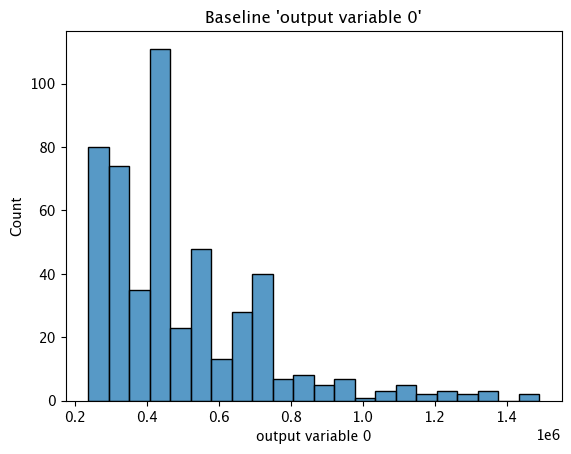

In [18]:
assay_baseline_from_dates.baseline_histogram()

### Assay Preview

Now that the baseline is defined, we look at different configuration options and view how the assay baseline and results changes.  Once we determine what gives us the best method of determining model drift, we can create the assay.

The following examples show different methods of previewing the assay, then how to configure the assay by collecting data from different locations.

#### Analysis List Chart Scores

Analysis List scores show the assay scores for each assay result interval in one chart.  Values that are outside of the alert threshold are colored red, while scores within the alert threshold are green.

Assay chart scores are displayed with the method [`wallaroo.assay.AssayAnalysisList.chart_scores(title: Optional[str] = None)`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay/#AssayAnalysisList.chart_scores), with ability to display an optional title with the chart.

The following example shows retrieving the assay results and displaying the chart scores for each window interval for `location_01`

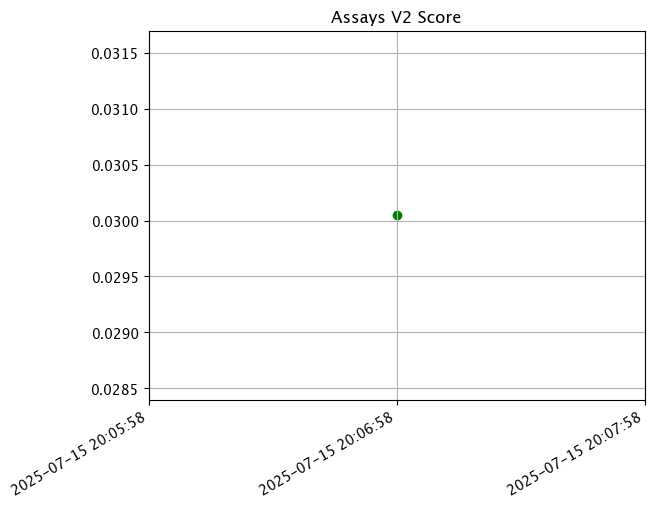

In [19]:
# Create the assay baseline
assay_baseline = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# set the location to the edge location
assay_baseline.window_builder().add_location_filter([location_01])

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now())

# Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# Preview the assay analyses
assay_results.chart_scores()

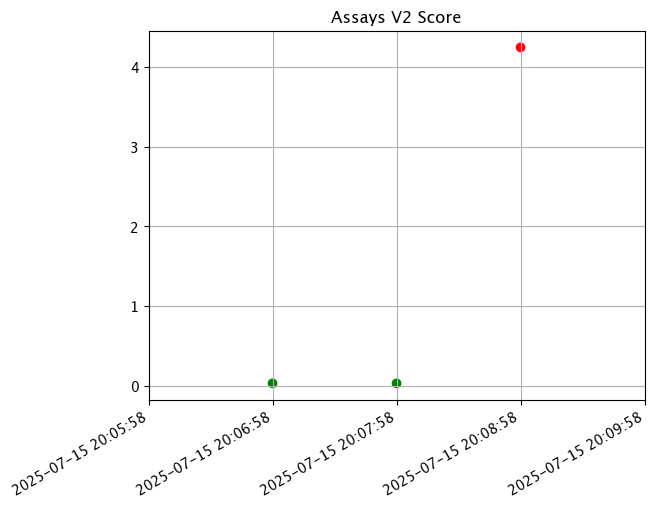

In [20]:
# Create the assay baseline
assay_baseline = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# set the location to the edge location
assay_baseline.window_builder().add_location_filter([location_01, location_02])

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now())

# Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# Preview the assay analyses
assay_results.chart_scores()

#### Analysis Chart

The method `wallaroo.assay.AssayAnalysis.chart()` displays a comparison between the baseline and an interval of inference data.

This is compared to the [Chart Scores](#analysis-list-chart-scores), which is a **list** of all of the inference data split into intervals, while the **Analysis Chart** shows the breakdown of one set of inference data against the baseline.

Score from the [Analysis List Chart Scores](#analysis-list-chart-scores) and each element from the [Analysis List DataFrame](#analysis-list-dataframe) generates 

The following fields are included.

| Field | Type | Description |
|---|---|---|
| **baseline mean** | **Float** | The mean of the baseline values. |
| **window mean** | **Float** | The mean of the window values. |
| **baseline median** | **Float** | The median of the baseline values. |
| **window median** | **Float** | The median of the window values. |
| **bin_mode** | **String** | The binning mode used for the assay. |
| **aggregation** | **String** | The aggregation mode used for the assay. |
| **metric** | **String** | The metric mode used for the assay. |
| **weighted** | **Bool** | Whether the bins were manually weighted. |
| **score** | **Float** | The score from the assay window. |
| **scores** | **List(Float)** | The score from each assay window bin. |
| **index** | **Integer/None** | The window index.  Interactive assay runs are `None`. |

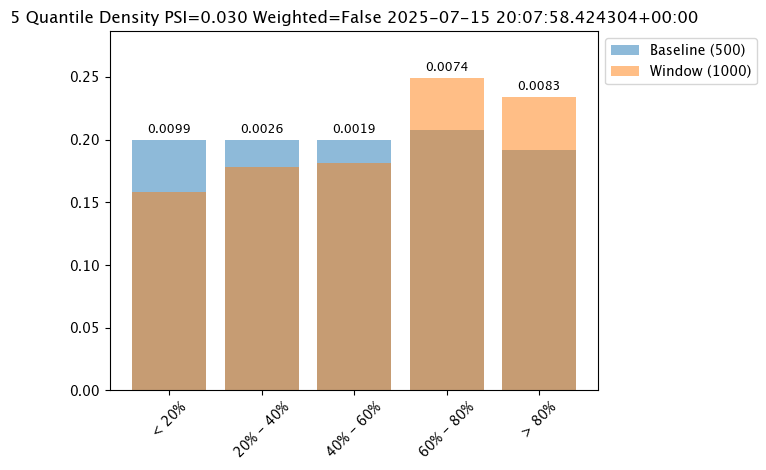

In [21]:
# Create the assay baseline
assay_baseline = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# set the location to the edge location
assay_baseline.window_builder().add_location_filter([location_01])

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now())

# Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# Preview the assay analyses
assay_results[0].chart()

#### Analysis List DataFrame

`wallaroo.assay.AssayAnalysisList.to_dataframe()` returns a DataFrame showing the assay results for each window aka individual analysis.  This DataFrame contains the following fields:

| Field | Type | Description |
|---|---|---|
| **assay_id** | *Integer/None* | The assay id.  Only provided from uploaded and executed assays. |
| **name** | *String/None* | The name of the assay.  Only provided from uploaded and executed assays. |
| **iopath** | *String/None* | The iopath of the assay.  Only provided from uploaded and executed assays. |
| **score** | *Float* | The assay score. |
| **start** | *DateTime* | The DateTime start of the assay window.
| **min** | *Float* | The minimum value in the assay window.
| **max**  | *Float* | The maximum value in the assay window.
| **mean** | *Float* | The mean value in the assay window.
| **median** | *Float* | The median value in the assay window.
| **std** | *Float* | The standard deviation value in the assay window.
| **warning_threshold** | *Float/None* | The warning threshold of the assay window.
| **alert_threshold** | *Float/None* | The alert threshold of the assay window.
| **status** | *String* | The assay window status.  Values are:  <ul><li>`OK`: The score is within accepted thresholds.</li><li>`Warning`: The score has triggered the `warning_threshold` if exists, but not the `alert_threshold`.</li><li>`Alert`: The score has triggered the the `alert_threshold`.</li></ul> |

For this example, the assay analysis list DataFrame is listed.  

From this tutorial, we should have 2 windows of dta to look at, each one minute apart.

In [22]:
# Create the assay baseline
assay_baseline = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# set the location to the edge location
assay_baseline.window_builder().add_location_filter([location_01])

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now())

# Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# Preview the assay analyses
assay_results.to_dataframe()

,id,assay_id,assay_name,iopath,pipeline_id,pipeline_name,workspace_id,workspace_name,score,start,min,max,mean,median,std,warning_threshold,alert_threshold,status
0,0,3f478cbf-73da-4f72-aa0e-2fe1e6197ccc,assay-demonstration-tutorial assay,out.variable.0,40,assay-demonstration-tutorial,12,run-anywhere-assay-demonstration-tutorial,0.030046,2025-07-15 20:06:58.424304+00:00,236238.65625,2016006.0,539489.484203,451046.9375,264051.03125,None,0.25,Ok


#### Configure Assays

Before creating the assay, **configure** the assay and continue to preview it until the best method for detecting drift is set.

##### Location Filter

This tutorial focuses on the assay configuration method `wallaroo.assay_config.WindowBuilder.add_location_filter`.

###### Location Filter Parameters

`add_location_filter` takes the following parameters.

| Parameter | Type | Description |
|---|---|---|
| **locations** | List(String) | The list of model deployment locations for the assay. |

###### Location Filter Example

By default, the `locations` parameter includes **all locations** as part of the pipeline.  This is seen in the default where no location filter is set, and of the inference data is shown.

For our examples, we will show different locations and how the assay changes.  For the first example, we set the location to `location_01` which was used to create the baseline, and included inferences that were likely to **not** trigger a model drift detection alert.

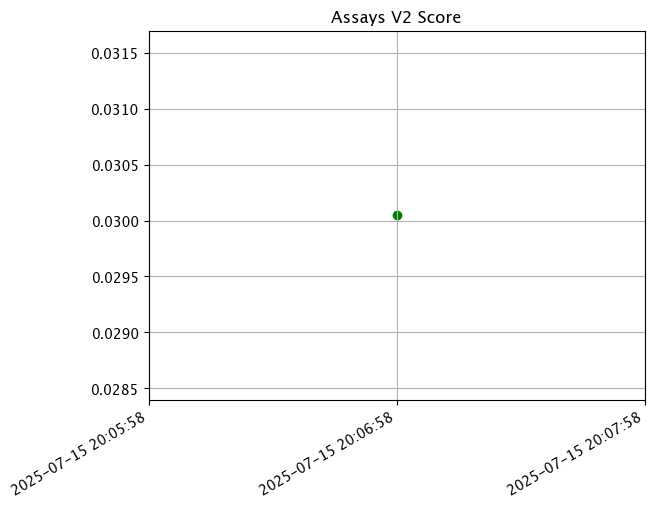

,id,assay_id,assay_name,iopath,pipeline_id,pipeline_name,workspace_id,workspace_name,score,start,min,max,mean,median,std,warning_threshold,alert_threshold,status
0,0,e3695ad8-8a79-4462-a424-f5f4c88e536f,assay-demonstration-tutorial assay,out.variable.0,40,assay-demonstration-tutorial,12,run-anywhere-assay-demonstration-tutorial,0.030046,2025-07-15 20:06:58.424304+00:00,236238.65625,2016006.0,539489.484203,451046.9375,264051.03125,None,0.25,Ok


In [23]:
# Create the assay baseline
assay_baseline = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# set the location to the edge location
assay_baseline.window_builder().add_location_filter([location_01])

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now())

# Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# Preview the assay analyses
assay_results.chart_scores()
assay_results.to_dataframe()

The next example includes `location_01` and `location_02`.  Since they were performed in distinct times, the model insights scores for each location is seen in the chart.

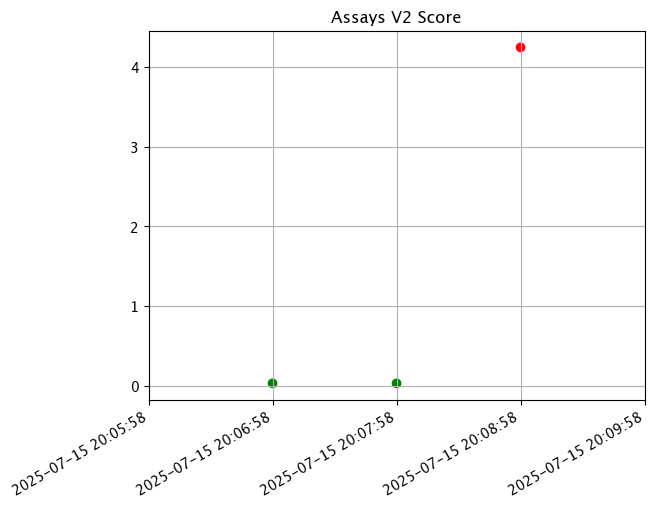

,id,assay_id,assay_name,iopath,pipeline_id,pipeline_name,workspace_id,workspace_name,score,start,min,max,mean,median,std,warning_threshold,alert_threshold,status
0,0,c1211c1a-5cea-46fe-8287-e5cb6801613d,assay-demonstration-tutorial assay,out.variable.0,40,assay-demonstration-tutorial,12,run-anywhere-assay-demonstration-tutorial,0.030046,2025-07-15 20:06:58.424304+00:00,2.362387e+05,2016006.0,5.394895e+05,4.510469e+05,264051.03125,None,0.25,Ok
1,0,c1211c1a-5cea-46fe-8287-e5cb6801613d,assay-demonstration-tutorial assay,out.variable.0,40,assay-demonstration-tutorial,12,run-anywhere-assay-demonstration-tutorial,0.030046,2025-07-15 20:07:58.424304+00:00,2.362387e+05,2016006.0,5.394895e+05,4.510469e+05,264051.03125,None,0.25,Ok
2,0,c1211c1a-5cea-46fe-8287-e5cb6801613d,assay-demonstration-tutorial assay,out.variable.0,40,assay-demonstration-tutorial,12,run-anywhere-assay-demonstration-tutorial,4.248209,2025-07-15 20:08:58.424304+00:00,1.514080e+06,2016006.0,1.871636e+06,1.946437e+06,163849.53125,None,0.25,Alert


In [26]:
# Create the assay baseline
assay_baseline = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# set the location to the edge location
assay_baseline.window_builder().add_location_filter([location_01, location_02])

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now())

# Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# Preview the assay analyses
assay_results.chart_scores()
assay_results.to_dataframe()

### Create Assay

With the assay previewed and configuration options determined, we officially create it by uploading it to the Wallaroo instance.

Once it is uploaded, the assay runs an analysis based on the window width, interval, and the other settings configured.

Assays are uploaded with the `wallaroo.assay_config.upload()` method. This uploads the assay into the Wallaroo database with the configurations applied and returns the assay id. Note that assay names **must be unique across the Wallaroo instance**; attempting to upload an assay with the same name as an existing one will return an error.

`wallaroo.assay_config.upload()` returns the assay id for the assay.

Typically we would just call `wallaroo.assay_config.upload()` after configuring the assay.  For the example below, we will perform the complete configuration in one window to show all of the configuration steps at once before creating the assay, and narrow the locations to `location_01` and `location_02`.  By default, **all** locations associated with a pipeline are included in the assay results unless the `add_location_filter` method is applied to specify location(s).

In [28]:
# Create the assay baseline
assay_baseline = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# set the location to the edge location
assay_baseline.window_builder().add_location_filter([location_01, location_02])

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now())

# Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

assay_id = assay_baseline.upload()


The assay is now visible through the Wallaroo UI by selecting the workspace, then the pipeline, then **Insights**.  The following is an example of another assay in the Wallaroo Dashboard.

![Sample assay in the UI](images/housepricesaga-sample-assay.png)

### Get Assay Info

Assay information is retrieved with the `wallaroo.client.get_assay_info()` which takes the following parameters.

| Parameter | Type | Description |
|---|---|---|
| **assay_id** | *Integer* (*Required*) | The numerical id of the assay. |

This returns the following:

| Parameter | Type | Description |
|---|---|---|
| *id* | *Integer* | The numerical id of the assay. |
| *name* | *String* | The name of the assay. |
| *active* | *Boolean* | `True`: The assay is active and generates analyses based on its configuration. `False`: The assay is disabled and will not generate new analyses. |
| *pipeline_name* | *String* | The name of the pipeline the assay references. |
| *last_run* | *DateTime* | The date and time the assay last ran. |
| *next_run* | *DateTime* | THe date and time the assay analysis will next run. |
| *alert_threshold* | *Float* | The alert threshold setting for the assay. |
| *baseline* | *Dict* | The baseline and settings as set from the assay configuration. |
| *iopath* | *String* | The `iopath` setting for the assay. |
| *metric* | *String* | The `metric` setting for the assay. |
| *num_bins* | *Integer* | The number of bins for the assay. |
| *bin_weights* | *List*/None | The bin weights used if any. |
| *bin_mode* | *String* | The binning mode used. |


In [29]:
display(wl.get_assay_info(assay_id))

Field,Value
ID,bdf36039-d2ed-4455-8653-803d22554bd5
Name,assays from date baseline
Active,True
Pipeline,assay-demonstration-tutorial
Workspace ID,12
Workspace Name,run-anywhere-assay-demonstration-tutorial
Monitoring,['out.variable.0']
Window Width,60 seconds
First Run,2025-15-Jul 20:07:58
End Run,2025-15-Jul 20:26:33


To wrap up the tutorial, we'll disable the assay to save resources.

In [30]:
wl.set_assay_active(assay_id=assay_id, active=False)